In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import wandb
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
mode = 'disabled'
# mode = 'online'

wandb.init(project='leafsnap', entity='dianna-ai', mode=mode)

In [3]:
config = wandb.config
config.img_size = 128
config.batch_size = 32
config.epochs = 10
config.learning_rate = 0.0005
config.weight_decay = 1e-5
config.kernel_size = 5  # must be an odd number to keep the image dimensions the same after convolution
config.pooling = 2
config.channels1 = 12
config.channels2 = 12
config.channels3 = 24
config.channels4 = 24
config.dropout = .4

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
dataset_root = os.path.expanduser('~/nlesc/DIANNA/datasets/leafsnap/leafsnap-dataset-30subset')

metadata = pd.read_csv(os.path.join(dataset_root, 'leafsnap-dataset-30subset-images.txt'), delimiter='\t')
metadata.head()

,file_id,image_path,species,source
0,77937,dataset/images/lab/Auto_cropped/diospyros_virg...,Diospyros virginiana,lab
1,77938,dataset/images/lab/Auto_cropped/diospyros_virg...,Diospyros virginiana,lab
2,77939,dataset/images/lab/Auto_cropped/diospyros_virg...,Diospyros virginiana,lab
3,77940,dataset/images/lab/Auto_cropped/diospyros_virg...,Diospyros virginiana,lab
4,77941,dataset/images/lab/Auto_cropped/diospyros_virg...,Diospyros virginiana,lab


In [6]:
def valid_file(fname):
    # dataset consists of .jpg images
    # converted to .bmp for faster loading
    return fname.endswith('.bmp')

transform = transforms.Compose([transforms.Resize(config.img_size),
                                transforms.CenterCrop(config.img_size),
                                transforms.ToTensor()])

train_data = datasets.ImageFolder(os.path.join(dataset_root, 'dataset/split/train'), transform=transform, is_valid_file=valid_file)
val_data = datasets.ImageFolder(os.path.join(dataset_root, 'dataset/split/validation'), transform=transform, is_valid_file=valid_file)
test_data = datasets.ImageFolder(os.path.join(dataset_root, 'dataset/split/test'), transform=transform, is_valid_file=valid_file)

num_classes = len(train_data.classes)
num_samples = len(train_data) + len(val_data) + len(test_data)

print(f'Number of classes: {num_classes}')
print(f'Total number of samples: {num_samples}')
print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(val_data)}')
print(f'Number of test samples: {len(test_data)}')

Number of classes: 30
Total number of samples: 7395
Number of training samples: 5917
Number of validation samples: 739
Number of test samples: 739


Text(0.5, 1.0, 'ulmus_rubra')

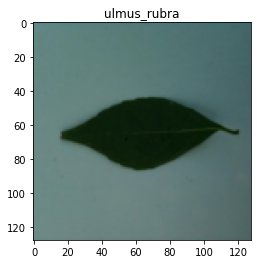

In [7]:
workers = min(12, os.cpu_count() - 1)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=config.batch_size, shuffle=True, num_workers=workers, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=config.batch_size, shuffle=True, num_workers=workers, pin_memory=True)

images, labels = next(iter(train_dataloader))
im = np.array(images[1].permute(1,2,0))
plt.imshow(im)
plt.title(train_data.classes[labels[0]])

In [8]:
class Network(nn.Module):
    def __init__(self, img_size, num_classes, kernel_size, pooling_size, num_channels, dropout):
        super().__init__()
        
        self.num = len(num_channels)
        
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        
        for i, out_channels in enumerate(num_channels):
            if i == 0:
                in_channels = 3
            else:
                in_channels = num_channels[i-1]
            padding = int((kernel_size - 1) / 2)
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding))
            self.bn_layers.append(nn.BatchNorm2d(out_channels))
            # no pooling layer for the last step
            if i < self.num - 1:
                self.pool_layers.append(nn.MaxPool2d(pooling_size, pooling_size))
        
        # image size has been reduced by a factor pooling_size as many times as there are pooling layres
        reduced_img_size = int(img_size / pooling_size ** len(self.pool_layers))
        self.final_layer_size = num_channels[-1] * reduced_img_size ** 2

        self.drop = nn.Dropout(dropout)

        self.fc1 = nn.Linear(self.final_layer_size, num_classes)        

    def forward(self, data):
        for i in range(self.num):
            conv = self.conv_layers[i]
            bn = self.bn_layers[i]
            data = F.relu(bn(conv(data)))
            # apply pooling except in the last step
            if i < self.num - 1:
                pool = self.pool_layers[i]
                data = pool(data)

        data = data.view(-1, self.final_layer_size)
        data = self.fc1(self.drop(data))
        return data
    
# Instantiate a neural network model 
channels = [config.channels1, config.channels2, config.channels3, config.channels4]
model = Network(config.img_size, num_classes, config.kernel_size, config.pooling, channels, config.dropout).to(device)

print(f'Number of trainable parameters: {sum([p.numel() for p in model.parameters()])}')

Number of trainable parameters: 210666


In [9]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
loss_func = nn.CrossEntropyLoss().to(device)


def accuracy(model_output, y_true):
    _, y_pred = torch.max(model_output, dim=1)
    return (y_pred == y_true).sum() / len(y_pred)


def train(model, train_data, optimizer, loss_func):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in tqdm.notebook.tqdm(train_data):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(images)
       
        loss = loss_func(predictions, labels)
        acc = accuracy(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        wandb.log({'train_loss': loss.item(), 'train_acc': acc.item()})

    epoch_loss /= len(train_data)
    epoch_acc /= len(train_data)
    
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, data, loss_func, train_mode=False):
    avg_loss = 0
    avg_acc = 0
    if train_mode:
        model.train()
    else:
        model.eval()
        
    for batch in data:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        predictions = model(images)
       
        loss = loss_func(predictions, labels)
        acc = accuracy(predictions, labels)
        
        avg_loss += loss.item()
        avg_acc += acc.item()

    avg_loss /= len(data)
    avg_acc /= len(data)
    
    return avg_loss, avg_acc

In [10]:
for epoch in range(config.epochs):
    # run training loop
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_func)
    # evalute on validation data, with same model settings as during training (i.e. including dropout)
    val_loss, val_acc = evaluate(model, val_dataloader, loss_func)

    wandb.log({'train_epoch_loss': train_loss, 'train_epoch_acc': train_acc})
    wandb.log({'val_epoch_loss': val_loss, 'val_epoch_acc': val_acc})

    print(f'train loss: {train_loss:.2f} | train acc: {train_acc:.2f}')
    print(f'val   loss: {val_loss:.2f} | val   acc: {val_acc:.2f}')

  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 2.26 | train acc: 0.34
val   loss: 1.68 | val   acc: 0.50


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 1.41 | train acc: 0.57
val   loss: 1.90 | val   acc: 0.45


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 1.09 | train acc: 0.66
val   loss: 2.52 | val   acc: 0.32


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 0.87 | train acc: 0.72
val   loss: 1.01 | val   acc: 0.66


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 0.68 | train acc: 0.78
val   loss: 0.86 | val   acc: 0.72


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 0.61 | train acc: 0.80
val   loss: 1.02 | val   acc: 0.67


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 0.51 | train acc: 0.83
val   loss: 1.44 | val   acc: 0.60


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 0.44 | train acc: 0.85
val   loss: 1.36 | val   acc: 0.65


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 0.40 | train acc: 0.87
val   loss: 2.01 | val   acc: 0.53


  0%|          | 0/185 [00:00<?, ?it/s]

train loss: 0.38 | train acc: 0.88
val   loss: 0.72 | val   acc: 0.78


In [11]:
test_loss, test_acc = evaluate(model, test_dataloader, loss_func, train_mode=False)
print(f'test loss: {test_loss:.2f} | test acc: {test_acc:.2f}')

test loss: 0.80 | test acc: 0.76
